In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import numpy as np
from os import listdir
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
import pydicom as dicom
import matplotlib.pyplot as plt
from dicompylercore import dicomparser, dvh, dvhcalc
from dicom_contour.contour import get_contour_file,get_roi_names, coord2pixels, cfile2pixels, plot2dcontour, slice_order, get_contour_dict, get_data,  create_image_mask_files
from preprocessing.get_plan_from_dicom import Plan, plot_DVH, structure_range, img_cut, resample
from preprocessing.get_plan_from_dicom import plot_3d_img, IndexTracker
from preprocessing.generate_data import get_plans
from dicom_contour.contour import get_ct_name_dict
from dicom_contour.dose import build_dose_volume
import pickle
from PIL import Image, ImageDraw
from copy import deepcopy
import math
#from model_training_evaluation.training import train_nn_model, run_training
from model_training_evaluation.predicting import predict_evaluation, evaluate, predict_batch, predict_unit_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [283]:
if __name__ == '__main__':
    dicom_path = './dicom_data'
    plan_save_path = './Data/plans'
    dataset_save_path = './Data/npy_dataset'
    
    get_plans(dicom_path, section = 'Lungs', section_size = (27, 37.5, 75), matrix_size = (16, 64, 128), plan_save_path = plan_save_path, dataset_save_path = dataset_save_path, save_npy = True, batch_size = 1)

work on patient  TMI_Evans
work on RS structure  TMLI 17423 Body
start structure extraction
finish extract contour
Elapsed time: 136.0633 seconds
start extract dose
finish extract dose
Elapsed time: 39.3585 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
Breasts <--------> Breasts
one structure Mask Data Shape: (16, 64, 128, 12)
scan shape and dose shape= (1, 16, 64, 128, 12) (1, 16, 64, 128, 1)
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 132.2768 seconds
start extract dose
finish extract dose
Elapsed time: 39.3087 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <

In [269]:
path = './dicom_data/TMI_Kane/'

In [270]:
plan = Plan()
plan.get_plan_mask(path)

work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 132.0679 seconds
start extract dose
finish extract dose
Elapsed time: 39.0330 seconds


defaultdict(None,
            {'BODY': {'mask': array([[[0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      ...,
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0]],
              
                     [[0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      ...,
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0]],
              
                     [[0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      ...,
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0],
                      [0, 0, 0, ..., 0, 0, 0]],
      

In [281]:
standard_name = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper', 'Rectum', 'Breasts']
PTV_VExP_Bone = ['PTV_Bone_Total', '.PTV2_Bone', 'PTV2_Bone', 'PTV_Bone']
plan.rename()

PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
BODY <--------> BODY
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
Rectum <--------> Rectum


In [279]:
plan.structures.keys()


dict_keys(['BODY', 'Bladder', 'Esophagus', 'Esophagus+Mar', 'Eyes', 'Eyes+Margin', 'GI_Lower', 'GI_Upper', 'Heart', 'Kidney_L', 'Kidney_R', 'Kidneys', 'Kidneys+Margin', 'Lenses', 'Lung_L', 'Lung_R', 'Lungs', 'OpticN/Chiasm', 'OralCavity', 'Parotids', 'PTV_Brain', 'PTV_Liver', 'PTV_LN', 'PTV_Skull', 'PTV_SpCord', 'PTV_Spleen', 'PTV_Testes', 'Rectum', 'Thyroid', 'Larynx', 'Avoid-post', 'Avoid-ant', 'Avoid-ant1', 'Skin', 'Ring1', 'PTV_VExP', 'PTV_Ribs'])

In [200]:
with open("plan.pickle", "wb") as file_1:
    pickle.dump(plan, file_1, -1)

PicklingError: Can't pickle <class 'preprocessing.get_plan_from_dicom.Plan'>: it's not the same object as preprocessing.get_plan_from_dicom.Plan

In [3]:
plan = pickle.load(open("plan_Chavez.pickle", "rb", -1))

<IPython.core.display.Javascript object>


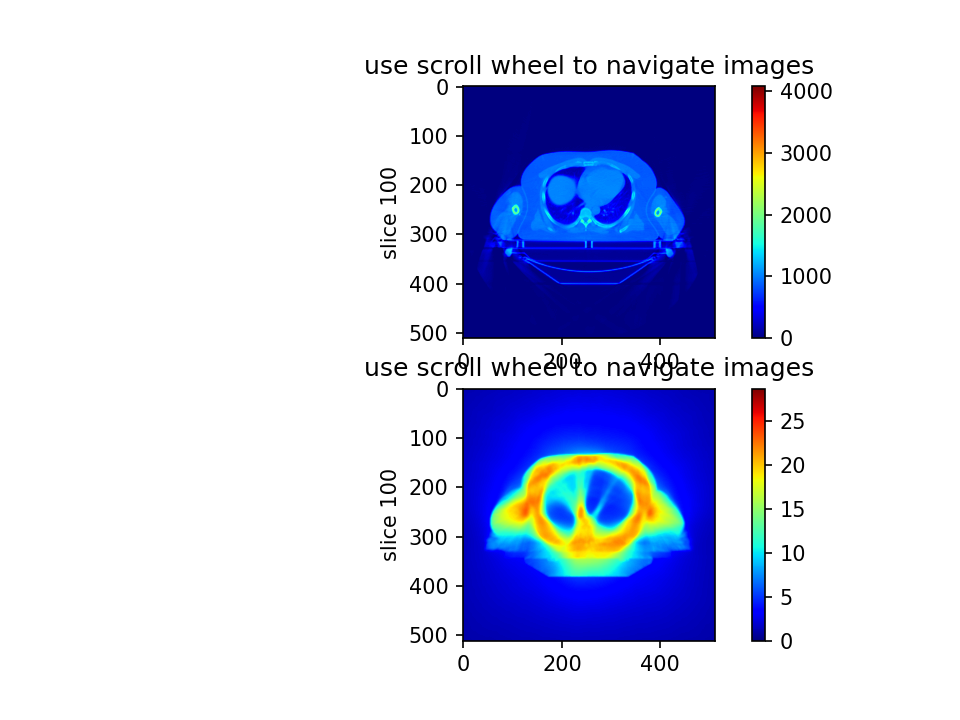

In [138]:
organ = 'Lungs'
fig, (ax1, ax2)= plt.subplots(2, 1)
max_img = np.max(plan.img_volume.flatten())
max_dose = np.max(plan.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
#tracker2 = IndexTracker(ax2, plan.structures[organ]['mask'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()



<IPython.core.display.Javascript object>


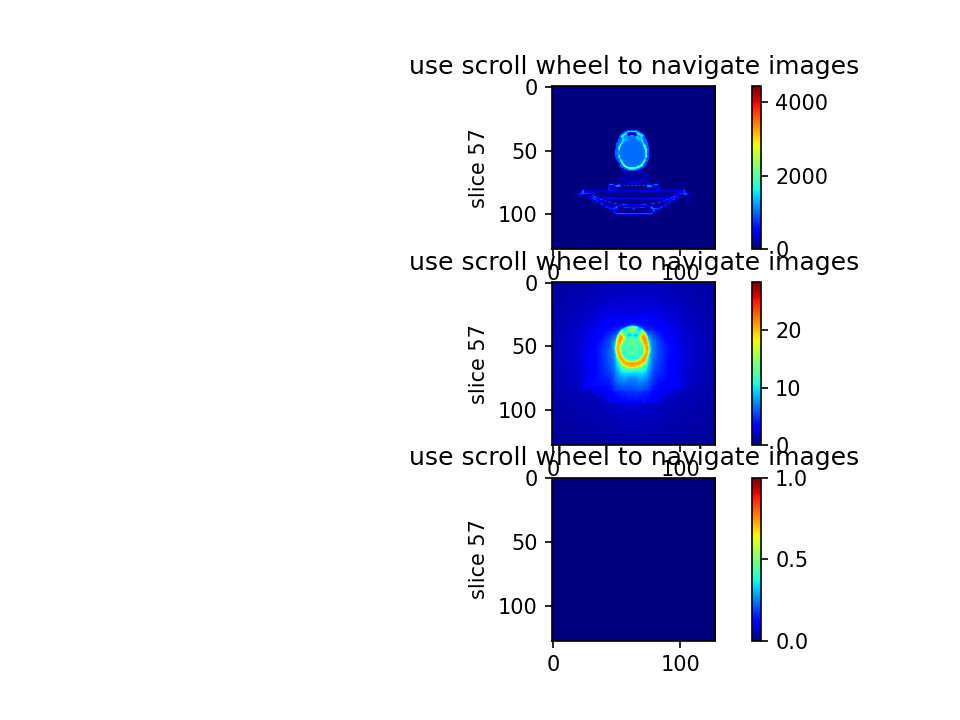

In [203]:
plan_new = deepcopy(plan)
plan_new = resample(plan_new,x_dim=128, y_dim=128, z_dim=64)
organ = 'Lungs'

print('old dimenstion is ', plan.img_volume.shape())
print('new dimenstion is ', plan_new.img_volume.shape())

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

x_dim:122, y_dim:179, z_dim:29, origin:[104, 221, 255]


<IPython.core.display.Javascript object>


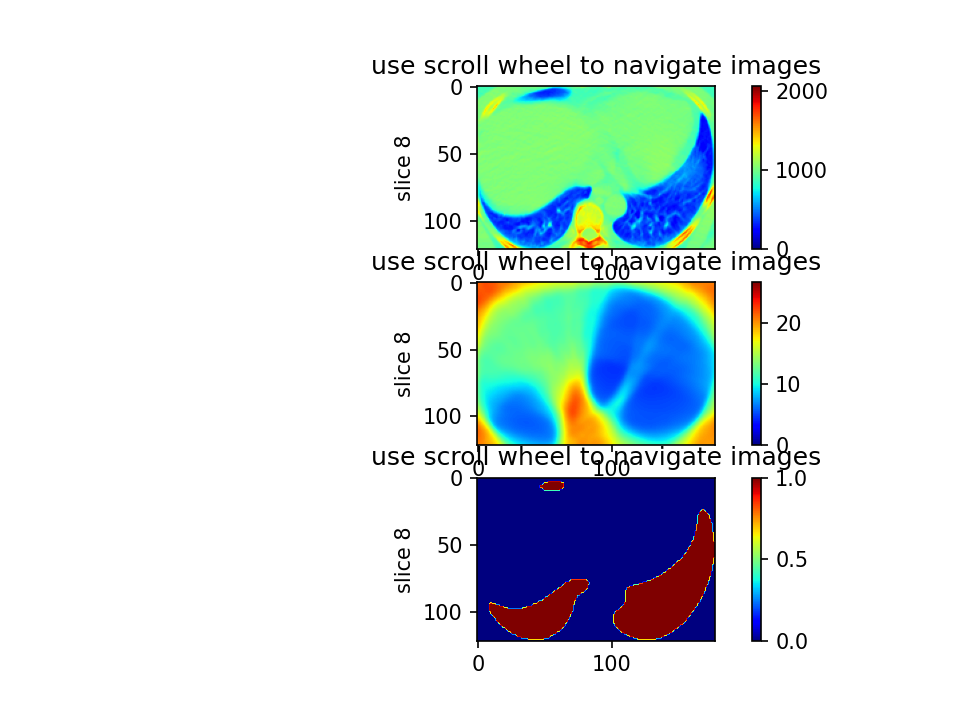

In [192]:
plan_new = deepcopy(plan)
zmin,zmax,xmin,xmax,ymin,ymax = structure_range(plan_new, 'Lungs')
origin = [math.floor((zmin+zmax)/2), math.floor((xmin+xmax)/2), math.floor((ymin+ymax)/2)]
x_dim = xmax-xmin+4; z_dim = zmax-zmin+4; y_dim = ymax-ymin+4
print('x_dim:{}, y_dim:{}, z_dim:{}, origin:{}'.format(x_dim,y_dim,z_dim,origin))
plan_new = img_cut(plan_new, x_dim, y_dim, z_dim, origin)
organ = 'Lungs'

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

<IPython.core.display.Javascript object>


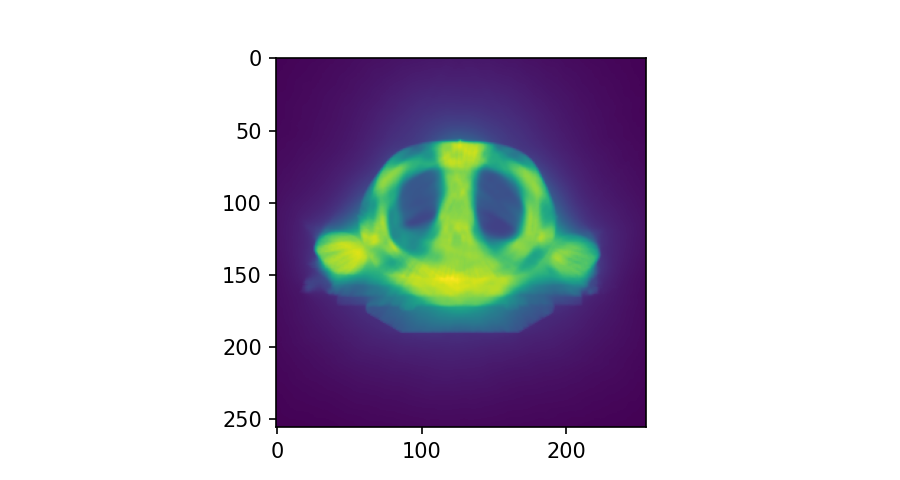

In [118]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Heart', 'PTV_SpCord', 'Lung_L','PTV_Skull','Bladder']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  8.015882836100516
True max organ dose is:  26.72603736307324


<IPython.core.display.Javascript object>


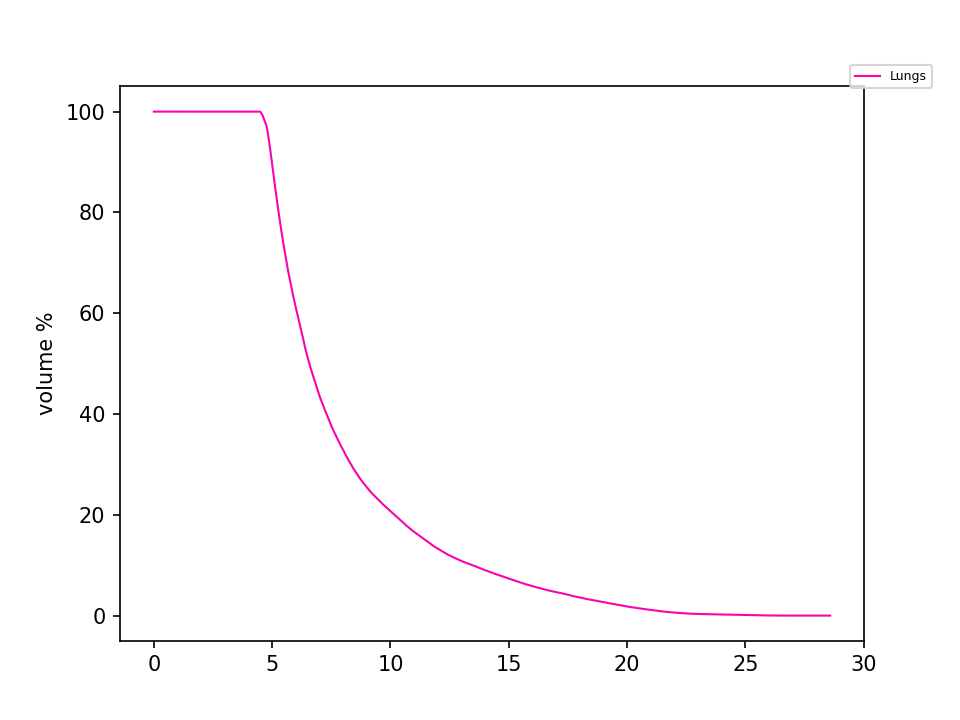

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 8.015882836100516},
 {'Lungs': 26.72603736307324},
 {'Lungs': 4.847290374411494},
 {'Lungs': 16.67239108130915})

In [196]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Lungs']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  7.988167042143717
True max organ dose is:  26.11972649371231


<IPython.core.display.Javascript object>


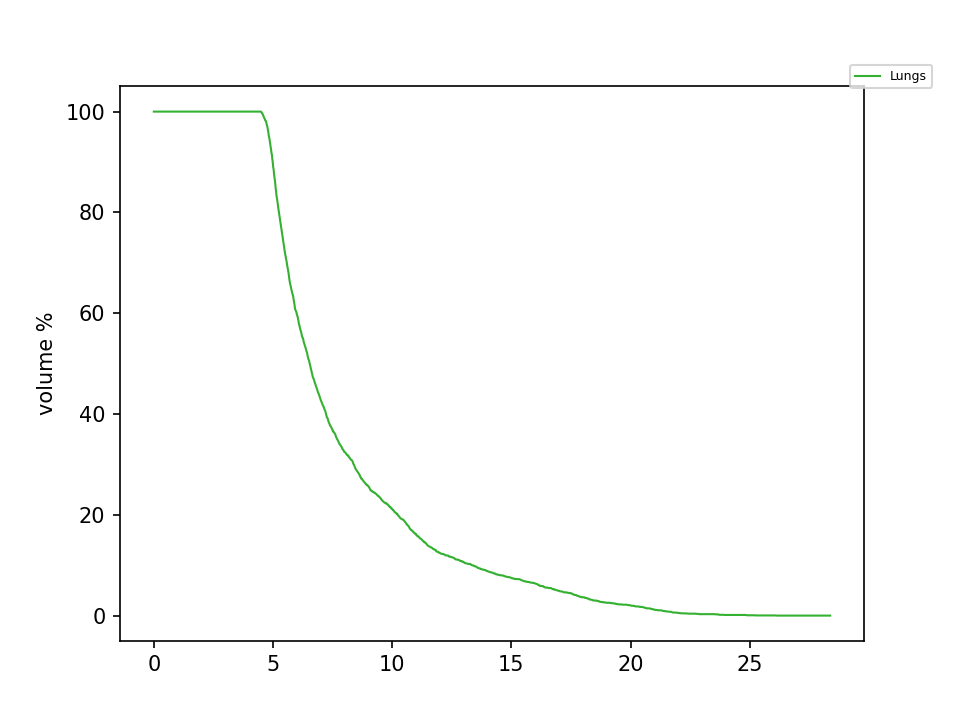

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 7.988167042143717},
 {'Lungs': 26.11972649371231},
 {'Lungs': 4.840816918198047},
 {'Lungs': 16.92156529763071})

In [206]:
plot_DVH(plan_new, standard_list)

In [289]:
if __name__ == '__main__':
    run_training(train_gan_model = False, input_size = (16, 64, 128, 12), parent_path='Data', training_npy_path = 'Data/npy_dataset/training/' , validation_npy_path = 'Data/npy_dataset/validation/')

NameError: name 'run_training' is not defined

In [43]:
contour_arr_orignal = plan.structures['Ring_1']['contour']

In [54]:
x=np.array([1,2,3])
y=np.array([4,5,6])
z = np.array([7])
xx,yy, zz = np.meshgrid(x,y,z)

In [65]:
dose_plane = dose_vol.interpolating_function(test)

In [46]:
contour_arr_orignal = plan.structures['Ring_1']['contour'][107,:,:]

In [47]:
np.shape(contour_arr_orignal)

(640, 640)

In [67]:
np.shape(dose_plane)

(3, 3)

In [161]:
arrays = [np.random.randn(3, 4) for _ in range(5)]
np.stack(arrays, axis=0).shape
test = np.stack(arrays, axis=0)
test = test>0
test

array([[[ True, False, False, False],
        [False,  True,  True,  True],
        [False,  True,  True,  True]],

       [[False, False, False, False],
        [ True, False, False, False],
        [False,  True, False,  True]],

       [[False, False, False, False],
        [False,  True,  True, False],
        [False,  True, False, False]],

       [[False,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True, False,  True]],

       [[ True, False,  True,  True],
        [ True, False, False, False],
        [False, False,  True,  True]]])

In [164]:
print(test.shape)
(x,y,z) = np.where(test)

(5, 3, 4)


In [5]:
x = np.array([1,2,3])
max(x-2,0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [274]:
y = 'abd'
y in x

False

In [250]:
data_folder = 'data_Chavez_NEW'
f = loadmat(data_folder)
scan = f['structset_2d_channel']
dose_img = f['doseset_2d']

In [251]:
scan.shape

(28, 128, 256, 13)

In [252]:
dose_img.shape

(28, 128, 256)

In [302]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.test.is_built_with_cuda()

False

In [298]:
tf.test.gpu_device_name()

''

In [301]:
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\Varian600c\\.conda\\envs\\tf-gpu\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


work on test patient  patient_1
BODY
True mean organ dose is:  16.381804
True max organ dose is:  25.437418
PTV_Ribs
True mean organ dose is:  19.552488
True max organ dose is:  24.295124
PTV_VExP
True mean organ dose is:  16.131584
True max organ dose is:  24.70505
PTV_SpCord
True mean organ dose is:  20.529755
True max organ dose is:  22.105028
PTV_LN
True mean organ dose is:  20.231358
True max organ dose is:  24.402323
PTV_Spleen
True mean organ dose is:  20.893131
True max organ dose is:  24.509392
PTV_Liver
True mean organ dose is:  12.431219
True max organ dose is:  18.242758
Lungs
True mean organ dose is:  8.18131
True max organ dose is:  22.448292
Heart
True mean organ dose is:  8.189642
True max organ dose is:  19.1572
Esophagus
True mean organ dose is:  6.5916743
True max organ dose is:  16.122543
GI_Upper
True mean organ dose is:  11.629593
True max organ dose is:  22.575605
Breasts
True mean organ dose is:  14.156942
True max organ dose is:  23.667065


<IPython.core.display.Javascript object>

BODY
True mean organ dose is:  13.381805
True max organ dose is:  22.437418
PTV_Ribs
True mean organ dose is:  16.552488
True max organ dose is:  21.295124
PTV_VExP
True mean organ dose is:  13.131585
True max organ dose is:  21.70505
PTV_SpCord
True mean organ dose is:  17.529755
True max organ dose is:  19.105028
PTV_LN
True mean organ dose is:  17.231356
True max organ dose is:  21.402323
PTV_Spleen
True mean organ dose is:  17.893131
True max organ dose is:  21.509392
PTV_Liver
True mean organ dose is:  9.431218
True max organ dose is:  15.242758
Lungs
True mean organ dose is:  5.181309
True max organ dose is:  19.448292
Heart
True mean organ dose is:  5.189642
True max organ dose is:  16.1572
Esophagus
True mean organ dose is:  3.5916746
True max organ dose is:  13.122543
GI_Upper
True mean organ dose is:  8.629593
True max organ dose is:  19.575605
Breasts
True mean organ dose is:  11.156942
True max organ dose is:  20.667065


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


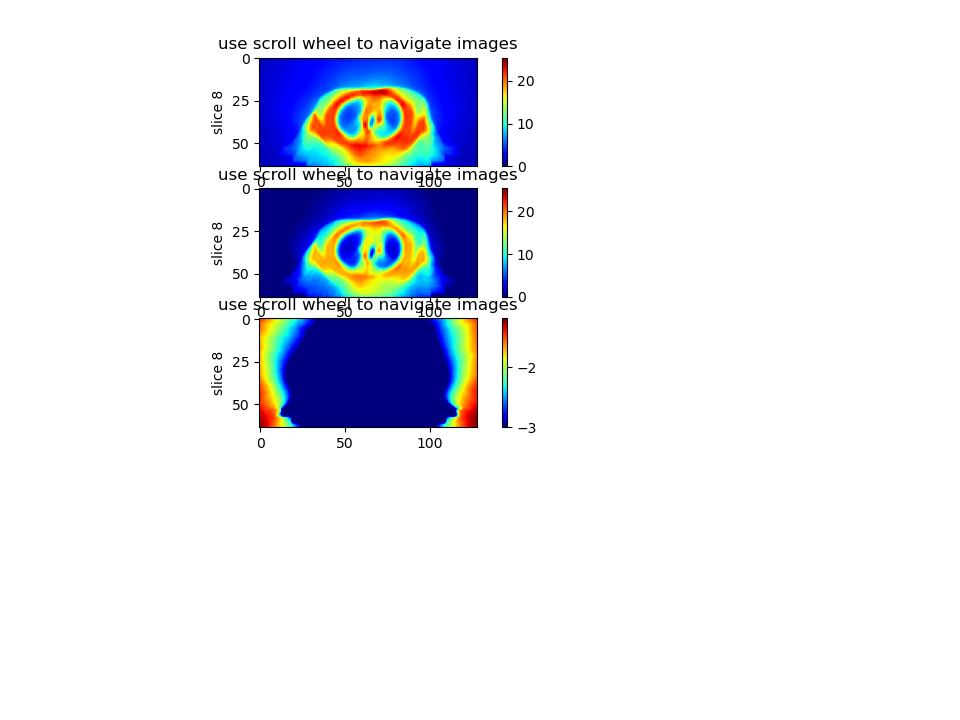

<IPython.core.display.Javascript object>

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,-0.183130,-0.117936,-0.469356,-0.558968,-0.135700,-0.132275
1,PTV_Ribs,-0.153433,-0.123482,-0.223083,-0.247652,-0.133455,-0.131696
2,PTV_VExP,-0.185971,-0.121433,-0.543690,-0.589840,-0.134589,-0.131719
3,PTV_SpCord,-0.146129,-0.135716,-0.169227,-0.178699,-0.138054,-0.137413
4,PTV_LN,-0.148285,-0.122939,-0.208485,-0.251754,-0.132299,-0.130066
5,PTV_Spleen,-0.143588,-0.122402,-0.178653,-0.197989,-0.128529,-0.126952
6,PTV_Liver,-0.241328,-0.164449,-0.356801,-0.386453,-0.198731,-0.184885
7,Lungs,-0.366690,-0.133640,-0.591023,-0.614097,-0.212245,-0.176521
8,Heart,-0.366316,-0.156599,-0.673310,-0.712197,-0.209916,-0.187241
9,Esophagus,-0.455120,-0.186075,-0.692183,-0.704218,-0.264288,-0.220885


work on test patient  patient_2
BODY
True mean organ dose is:  17.981836
True max organ dose is:  26.973219
PTV_Ribs
True mean organ dose is:  14.219483
True max organ dose is:  24.234566
PTV_VExP
True mean organ dose is:  20.654083
True max organ dose is:  26.973219


C:\ddu\radiotherapy-dose-prediction\preprocessing\get_plan_from_dicom.py:172: RuntimeWarning: Mean of empty slice.
  tracker2 = IndexTracker(ax2, self.dose_volume, fig,0,max_dose)
C:\Users\Varian600c\.conda\envs\tf-gpu\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


ValueError: zero-size array to reduction operation maximum which has no identity

In [21]:
predict_unit_test()